# STEP 1 -IMPORT ALL NECESSARY LIBRARIES

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')  

# STEP 2 -IMPORT DATA AND PRE PROCESSING 

In [4]:
data = pd.read_csv("water_potability.csv")

In [5]:
data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [6]:
data.shape #To check the shape of the data

(3276, 10)

In [7]:
data.isnull().sum() #To check if there are any missing values

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [9]:
# Impute missing values with median
data['ph'].fillna(data['ph'].median(), inplace=True)
data['Sulfate'].fillna(data['Sulfate'].median(), inplace=True)
data['Trihalomethanes'].fillna(data['Trihalomethanes'].median(), inplace=True)

In [10]:
# Verify no missing values
data.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

# step 3 - EDA

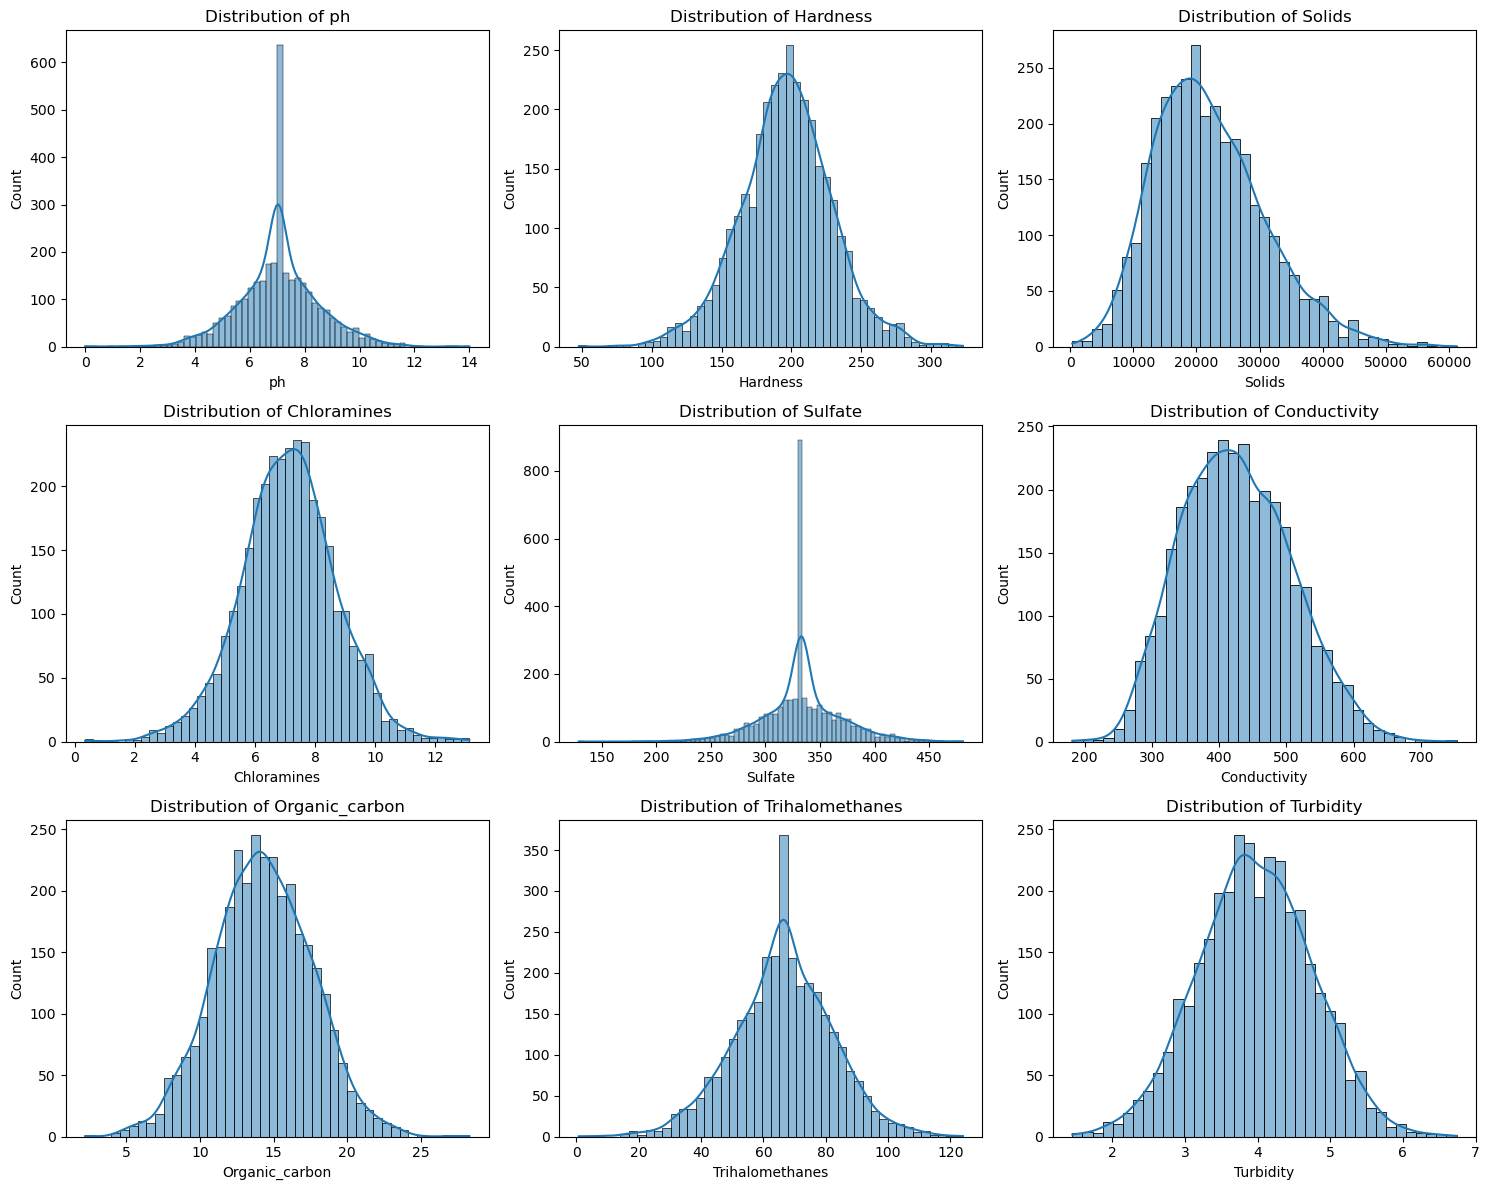

In [11]:
# Visualize distributions
plt.figure(figsize=(15, 12))
for i, column in enumerate(data.columns[:-1], 1):
    plt.subplot(3, 3, i)
    sns.histplot(data[column], kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

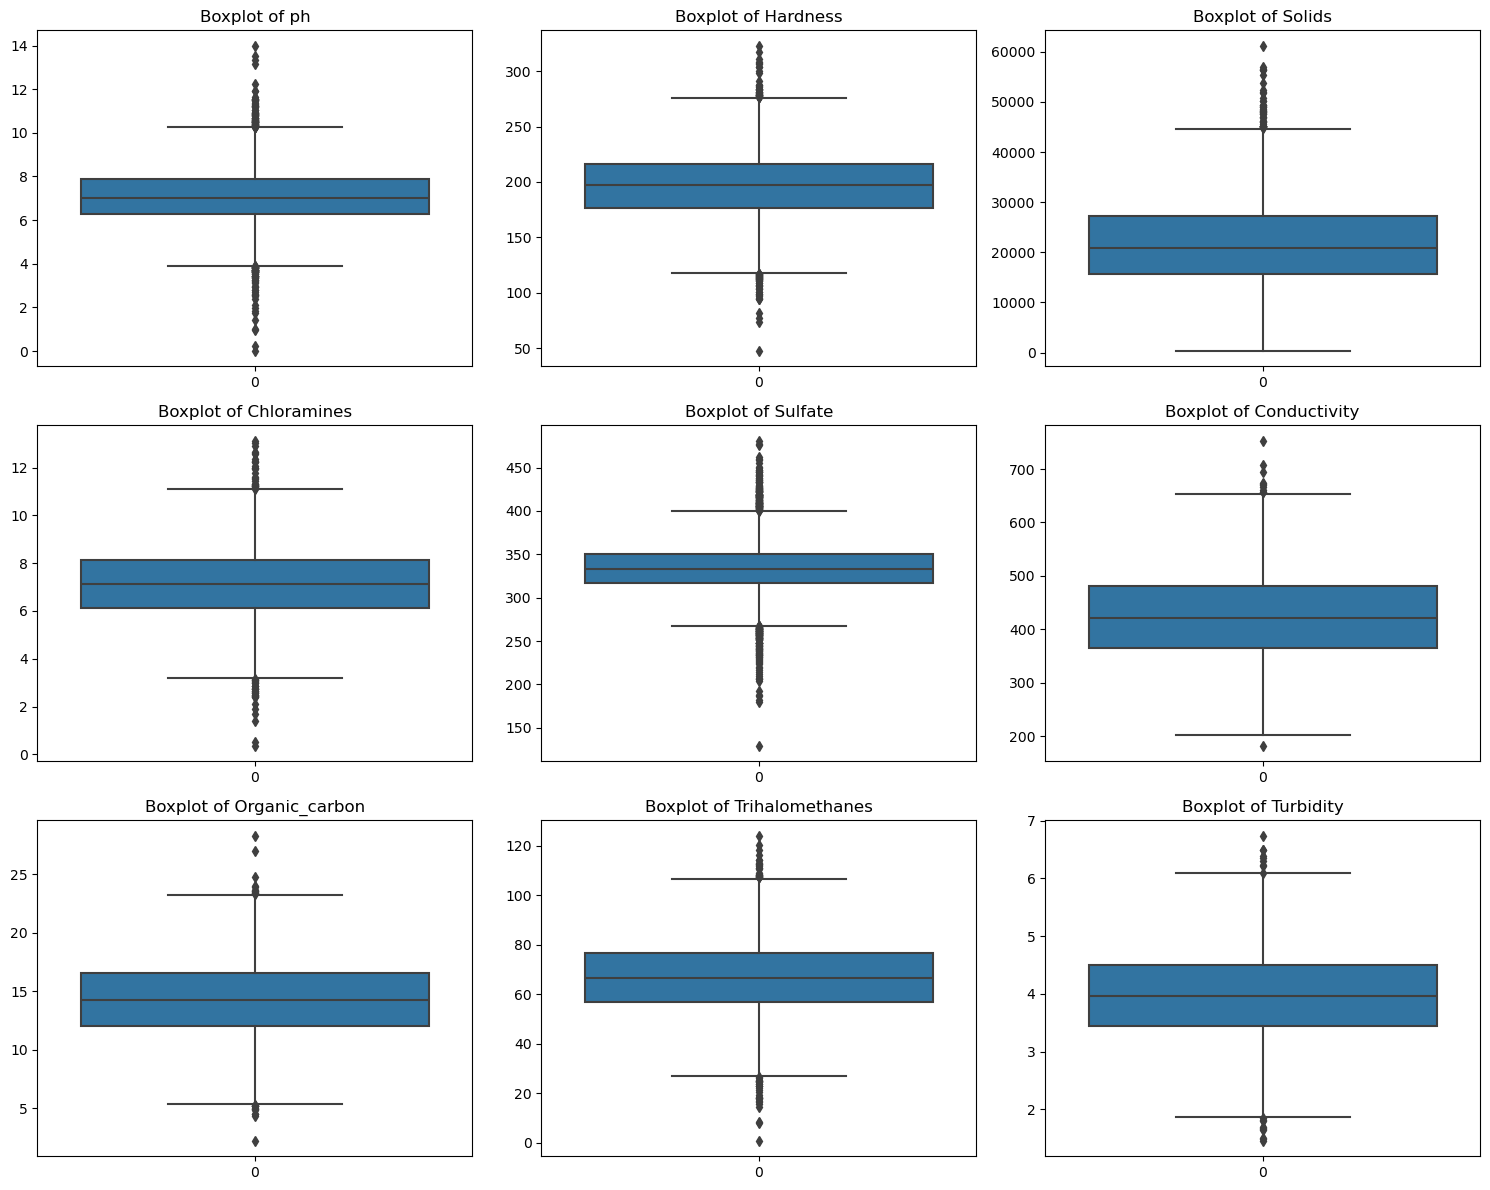

In [12]:
# Visualize outliers using boxplots
plt.figure(figsize=(15, 12))
for i, column in enumerate(data.columns[:-1], 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data[column])
    plt.title(f'Boxplot of {column}')
plt.tight_layout()
plt.show()

# STEP 4 - SPLIT THE DATA

In [13]:
# Feature Scaling
scaler = StandardScaler()
X = data.drop('Potability', axis=1)
y = data['Potability']

In [14]:
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [15]:
# Handling class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_scaled, y)

In [16]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

In [17]:
X_train.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
1575,-0.025474,2.052888,-0.609439,0.401783,-0.014799,0.019878,0.866776,0.723208,0.432246
506,-0.025474,0.667159,2.286609,-0.499796,-0.250891,0.952017,0.431474,-1.135855,0.462972
3592,-0.025474,0.687806,-0.054950,-0.070979,1.127946,-1.427809,-0.845356,-0.166778,-0.094950
3847,0.394484,-0.287042,-0.442823,-0.063198,-1.544826,-0.345954,-0.102454,1.181541,1.369937
3670,0.333100,0.035564,-0.698787,0.338397,-0.177698,-0.253501,1.666341,1.500453,-0.477973


In [18]:
# Initialize models
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVC": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False)}

In [19]:
# Training and cross-validation
model_scores = {}
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    model_scores[name] = np.mean(cv_scores)
    print(f"{name} CV Accuracy: {np.mean(cv_scores):.4f}")

Decision Tree CV Accuracy: 0.6302
Random Forest CV Accuracy: 0.7240
SVC CV Accuracy: 0.6690
KNN CV Accuracy: 0.6496
XGBoost CV Accuracy: 0.6743


In [20]:
# Hyperparameter tuning for Random Forest as an example
param_grid = {
    'n_estimators': [ 200],
    'max_depth': [ 30],
    'min_samples_split': [2]
}

In [21]:
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [30], 'min_samples_split': [2],
                         'n_estimators': [200]},
             scoring='accuracy')

In [22]:
print("\nBest parameters for Random Forest:")
print(grid_search.best_params_)


Best parameters for Random Forest:
{'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 200}


In [23]:
# Evaluate the tuned Random Forest model
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)

In [24]:
# Evaluation metrics
print("\nModel Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")


Model Evaluation:
Accuracy: 0.7350
Precision: 0.7425
Recall: 0.7315
F1 Score: 0.7370


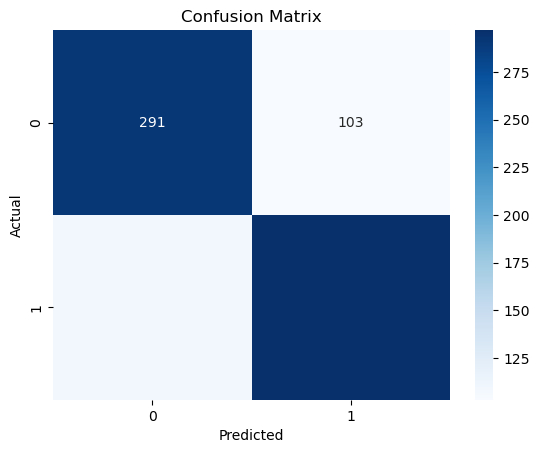

In [25]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [26]:
# ROC Curve and AUC Score
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)


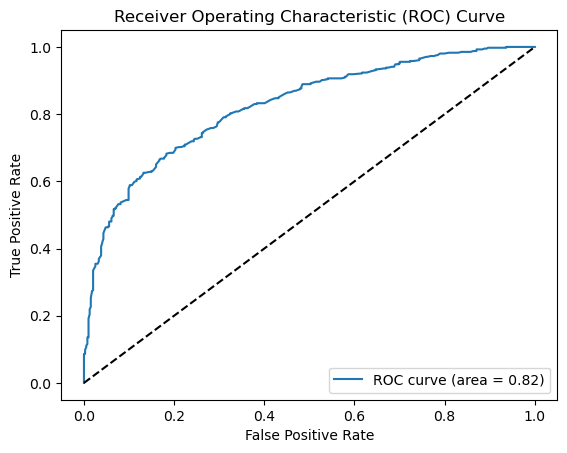

In [27]:
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


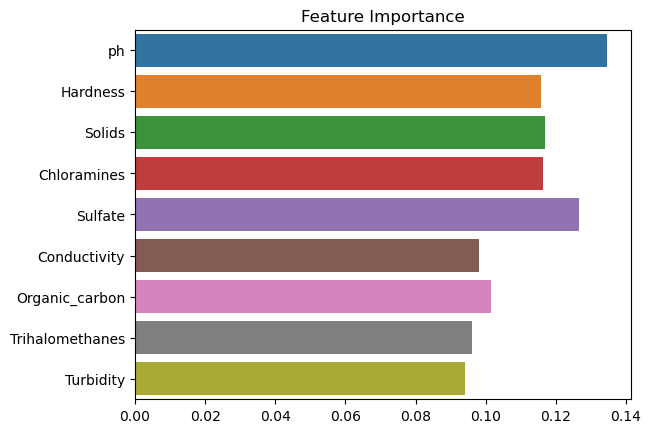

In [28]:
# Feature importance for tree-based models
importances = best_rf.feature_importances_
features = X.columns
sns.barplot(x=importances, y=features)
plt.title('Feature Importance')
plt.show()


In [29]:
print("\nProject completed successfully!")


Project completed successfully!


In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
import pickle

# Load your dataset
df = pd.read_csv('water_potability.csv')  # Replace with the correct CSV file

# Split the data into features and target
X = df.drop('Potability', axis=1)
y = df['Potability']

# Handle missing values by imputing
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Train the RandomForestClassifier model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Save the model again using the current version of scikit-learn
with open('water_potability_model.pkl', 'wb') as file:
    pickle.dump(model, file)

print('Model retrained and saved successfully!')


Model retrained and saved successfully!


In [41]:
#joblib.dump(best_rf, 'water_potability_model.pkl')

In [13]:
import sklearn
print(sklearn.__version__)


1.2.2
